# Get the HPS model to run
- get the inputs correct
- run through all steps
- get an accuracy estimate

In [1]:
%matplotlib inline

In [2]:
import os
import sys
sys.path.append('/home/surchs/git/HPS')
from hps.predic import high_confidence
from hps.visu import hps_visu
sys.path.append('/home/surchs/git/HPS/examples/')
import visu_demo

import numpy as np
import pandas as pd
import nibabel as nib
import sklearn as skl
import scipy.io as sio
import seaborn as sbn
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedKFold

In [3]:
os.cpu_count()

32

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Paths
root_p = '/home/surchs/sim_big/PROJECT/abide_hps/'
# Pheno
sample_p = os.path.join(root_p, 'pheno', 'strict_abide1_nopsm.csv')
# Data
mask_p = os.path.join(root_p, 'mask', 'MIST_mask.nii.gz')
subtype_fc_p = os.path.join(root_p, 'subtypes', 'subtypes_fc_nopsm.npz')
subtype_ct_p = os.path.join(root_p, 'subtypes', 'subtypes_ct_nopsm.npz')

In [6]:
# Load data
sample = pd.read_csv(sample_p)
sample['DX_CODE'] = sample['DX_GROUP'].replace({'Autism':1, 'Control':0})
s_fc = np.load(subtype_fc_p)
s_ct = np.load(subtype_ct_p)

In [12]:
# Reshape FC to add to the table
fc_weights = np.reshape(s_fc['weights'], (s_fc['weights'].shape[0], 5*20))
fc_cols = ['fc_n{}_s{}'.format(nid+1, sid+1) for sid in range(5) for nid in range(20)]
# Same for CT
ct_weights = s_ct['weights']
ct_cols = ['ct_s{}'.format(sid+1) for sid in range(5)]
# Combine both
weights = np.concatenate((ct_weights, fc_weights),1)
cols = ct_cols + fc_cols
# Into a pandas DF
w_data = pd.DataFrame(data=weights, columns=cols)
# Combine both for the full dataset
dataset = sample.join(w_data)

In [13]:
# Select the features
scaler = skl.preprocessing.StandardScaler()
# Add BV to the subtype weights
col_features = ['BV', 'AGE_AT_SCAN', 'FD_scrubbed', ] + cols

# Build features
x_ = dataset.loc[:, col_features]
# Take the numeric diagnosis code
y = dataset.loc[:, ['DX_CODE']].values.squeeze()
# Normalize
X = scaler.fit_transform(x_)

# Run the CV model

In [14]:
ohe = skl.preprocessing.OneHotEncoder(sparse=False)
ohe.fit(y.reshape(-1, 1))
labels = ohe.transform(y.reshape(-1, 1))

In [ ]:
scores_s1=[]
scores_s2 = []
y_target = []

skf = StratifiedKFold(n_splits=10)
it = 1
for train_index, val_index in skf.split(X,y):
    X_training, X_val = X[train_index], X[val_index]
    y_training, y_val = y[train_index], y[val_index]
        
    hps = high_confidence.TwoStagesPrediction(verbose=False,
                                          n_iter=1000,
                                          shuffle_test_split=0.5,
                                            gamma=0.98,
                                          min_gamma=0.95,
                                          thresh_ratio=0.1)
    
    hps.fit(X_training, y_training)
    
    scores, dic_results = hps.predict(X_val)
    
    # Test in validation sample
    acc = skl.metrics.accuracy_score(y_val, (dic_results['s1_df'][:,0]>0).astype(float))
    tmp_mask = (dic_results['s2_hat'][:,1]>0) & (dic_results['s1_df'][:,0]>0)
    acc_s2 = skl.metrics.accuracy_score(y_val, (dic_results['s2_df'][:,1]>0).astype(float))
    
    scores_s1.append(dic_results['s1_hat'])
    scores_s2.append(dic_results['s2_hat'])
    
    print('CV fold {} classifying...'.format(it))
    it += 1
    
    plt.figure()
    plt.hist(hps.training_hit_probability[y_training==0],10)
    plt.figure()
    plt.hist(hps.training_hit_probability[y_training==1],10)
    
    y_target.append(y_val)

Stage 1


In [ ]:
scores_s1 = np.vstack(scores_s1)
scores_s2 = np.vstack(scores_s2)
y_target = np.hstack(y_target)

########################
print('##########################')
# S1
y_mb = ohe.transform(y_target[:,np.newaxis])
pred_y_ = scores_s1

print('Stage 1 (BASE)')
hps_visu.print_scores(hps_visu.scores(y_mb, pred_y_))


# S2
y_mb = ohe.transform(y_target[:,np.newaxis])
pred_y_ = scores_s2

print('Stage 2 (HPS)')
hps_visu.print_scores(hps_visu.scores(y_mb, pred_y_)) 
print('##########################')

That looks pretty good, let's run this on the entire training set and see if it generalizes to the validation set

# Run the one-pass model

Stage 1
Stage 2


(array([ 23.,  17.,  15.,  11.,  12.,  12.,   9.,  12.,  18.,  53.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

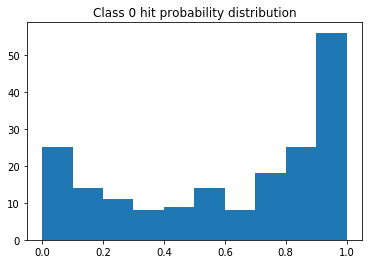

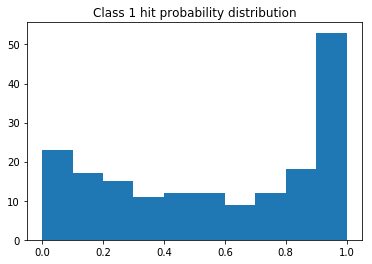

In [16]:
res_hitproba = []

hps = high_confidence.TwoStagesPrediction(verbose=False,
                                          n_iter=1000,
                                          shuffle_test_split=0.5,
                                          gamma=0.98,
                                          min_gamma=0.95,
                                          thresh_ratio=0.1)
hps.fit(X,y)
res_hitproba = hps.training_hit_probability

plt.figure()
plt.title('Class 0 hit probability distribution')
plt.hist(hps.training_hit_probability[y==0],10)
plt.figure()
plt.title('Class 1 hit probability distribution')
plt.hist(hps.training_hit_probability[y==1],10)

In [17]:
skl.metrics.accuracy_score(y, hps.basemodel.decision_function(X)>0)

0.70540540540540542

In [20]:
# Basemodel
print(skl.metrics.classification_report(y, hps.basemodel.decision_function(X)>0))

             precision    recall  f1-score   support

          0       0.71      0.72      0.71       188
          1       0.70      0.69      0.70       182

avg / total       0.71      0.71      0.71       370



In [22]:
# HPS model
print(skl.metrics.classification_report(y, hps.confidencemodel.decision_function(X)[:, 1]>0))

             precision    recall  f1-score   support

          0       0.56      1.00      0.72       188
          1       1.00      0.20      0.33       182

avg / total       0.78      0.61      0.53       370



In [23]:
array_results, dict_results = hps.predict(X)

In [25]:
#ind_hps = (dict_results['s1_df'].flatten()>0).astype(float)
ind_hps = (dict_results['s2_df'][:,1]>0).astype(float)
#ind_hps2 = dict_results['s2_df'].flatten()>0
lr_decision = dict_results['s2_df'][:,1]

In [78]:
print(skl.metrics.classification_report(y, ind_hps))

             precision    recall  f1-score   support

          0       0.56      1.00      0.72       188
          1       1.00      0.20      0.33       182

avg / total       0.78      0.61      0.53       370



## Get a hold of the feature weights in the model

In [27]:
# Get the feature weights for class 1 / second stage (not sure which)
feature_weights = hps.confidencemodel.clfs[1].coef_
# Get the non-zero weights
non_zero = np.where(feature_weights!=0)[1]

In [28]:
col_nonzero = [col_features[ind] for ind in non_zero]
feature_type = list()
for col in col_nonzero:
    if 'ct' in col:
        feature_type.append('Anatomical')
    elif 'fc' in col:
        feature_type.append('Functional')
    else:
        feature_type.append('Phenotype')
data = {'weights':feature_weights[0, non_zero],
            'feature':col_nonzero,
            'feature_type':feature_type}
weights = pd.DataFrame(data=data)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39]), <a list of 40 Text xticklabel objects>)

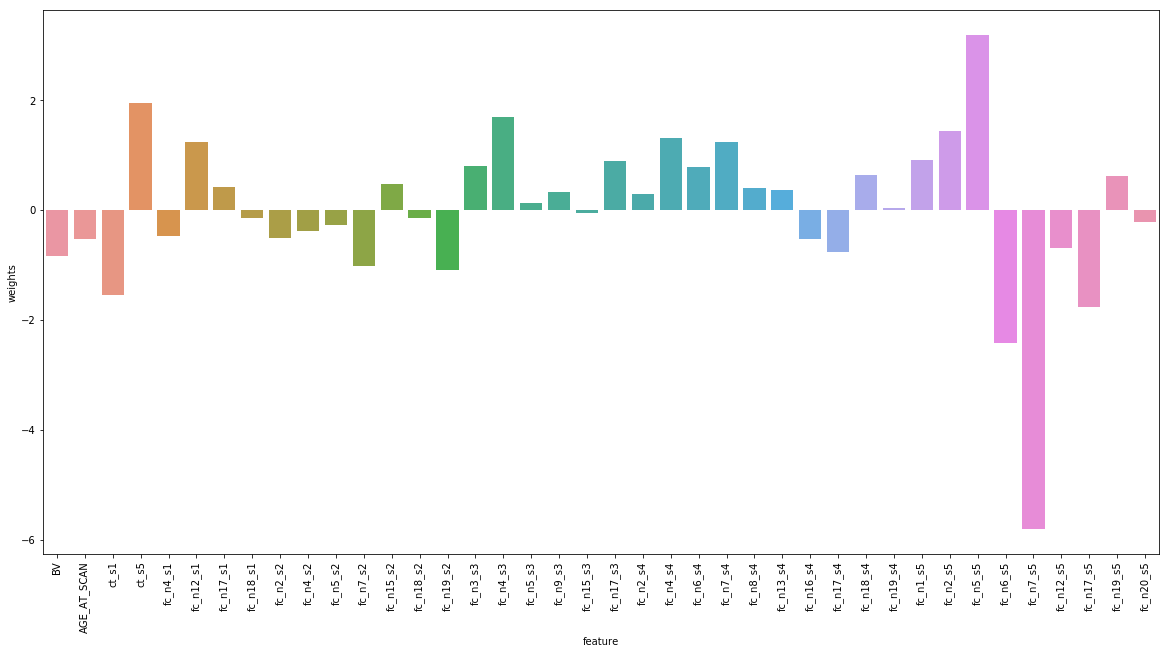

In [29]:
f = plt.figure(figsize=(20,10))
ax = f.add_subplot(111)
#g = sbn.barplot(x='feature', y='weights', data=weights, hue='feature_type', ax=ax)
g = sbn.barplot(x='feature', y='weights', data=weights, ax=ax)
plt.xticks(rotation=90)

# Look at the composition of the groups

In [32]:
# Identify people classified as easy cases
HPS_ind = ind_hps==1

In [115]:
# Give me three classes here
asd_hps = [True if HPS_ind[rid]==1 and row['DX_GROUP']=='Autism' else False for rid, row in sample.iterrows()]
asd_ns = [True if HPS_ind[rid]==0 and row['DX_GROUP']=='Autism' else False for rid, row in sample.iterrows()]
tdc = [True if row['DX_GROUP']=='Control' else False for rid, row in sample.iterrows()]
group = list()
for rid, row in sample.iterrows():
    if asd_hps[rid]:
        group.append('ASD_HPS')
    elif asd_ns[rid]:
        group.append('ASD_NS')
    else:
        group.append('TDC')
results = sample.copy()
results['Group'] = group
# Remove missing values
results.replace({col:{-9999:None} for col in results.columns}, inplace=True)

## Age

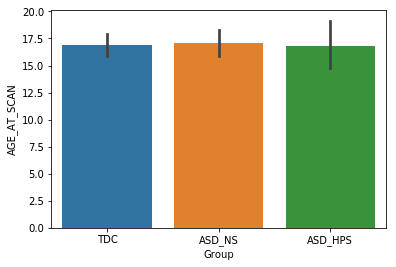

In [63]:
sbn.barplot(x='Group', y='AGE_AT_SCAN', data=results)

No age differences. Nice, nice

## Motion

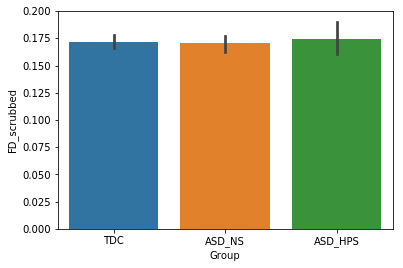

In [64]:
sbn.barplot(x='Group', y='FD_scrubbed', data=results)

Also no apparent motion differences, maybe a slight trend for the ASD HPS guys

## FIQ
Now for the more relevant stuff

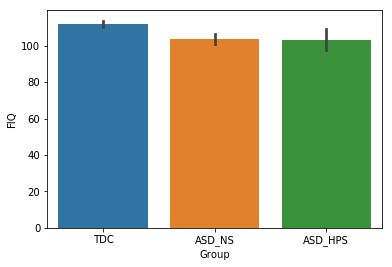

In [65]:
sbn.barplot(x='Group', y='FIQ', data=results)

No difference between the ASD groups

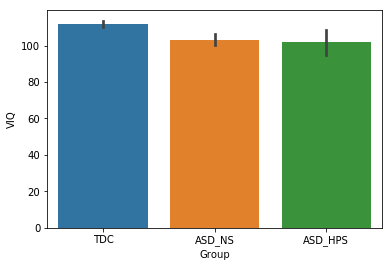

In [66]:
sbn.barplot(x='Group', y='VIQ', data=results)

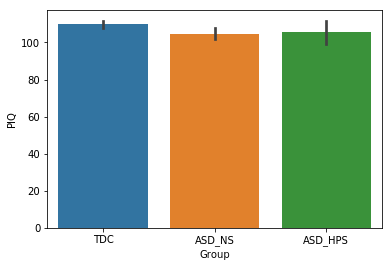

In [67]:
sbn.barplot(x='Group', y='PIQ', data=results)

## SRS

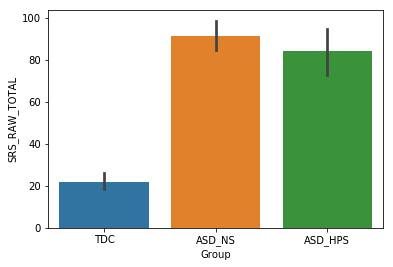

In [72]:
sbn.barplot(x='Group', y='SRS_RAW_TOTAL', data=results)

If anything, we have found less severe cases here, it seems

## Handedness

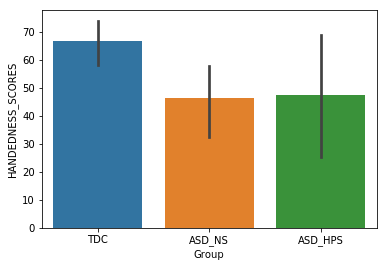

In [76]:
sbn.barplot(x='Group', y='HANDEDNESS_SCORES', data=results)

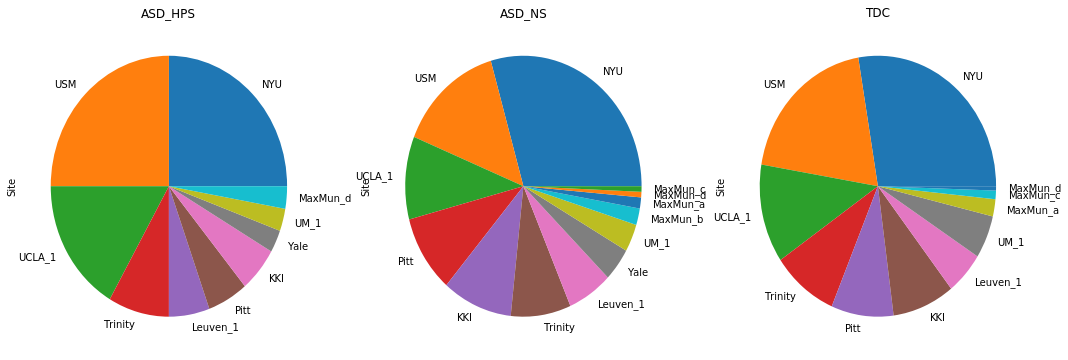

In [98]:
f = plt.figure(figsize=(18, 6))
ax1 = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)
for rid, g in enumerate(results.groupby('Group')):
    ax = f.add_subplot(1,3,rid+1)
    g[1]['Site'].value_counts().plot.pie(ax=ax)
    ax.set_title(g[0])

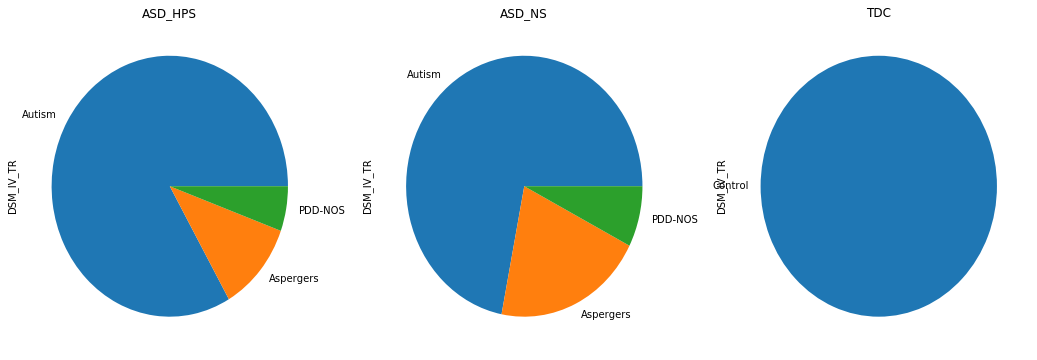

In [97]:
f = plt.figure(figsize=(18, 6))
ax1 = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)
for rid, g in enumerate(results.groupby('Group')):
    ax = f.add_subplot(1,3,rid+1)
    g[1]['DSM_IV_TR'].value_counts().plot.pie(ax=ax)
    ax.set_title(g[0])

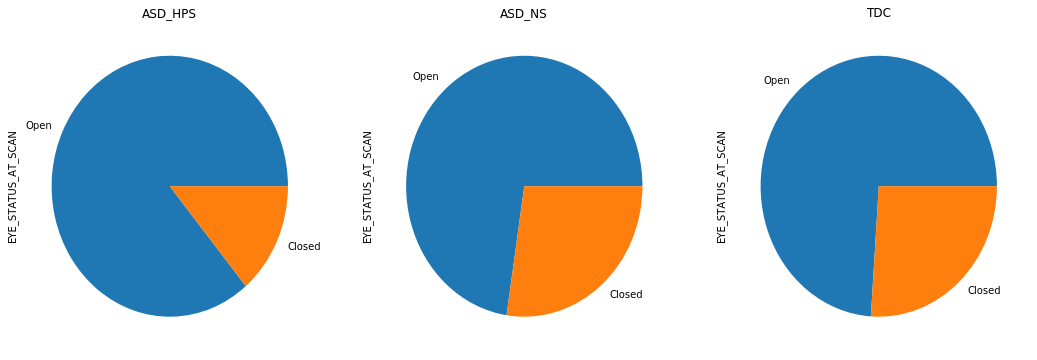

In [122]:
f = plt.figure(figsize=(18, 6))
ax1 = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)
for rid, g in enumerate(results.groupby('Group')):
    ax = f.add_subplot(1,3,rid+1)
    g[1]['EYE_STATUS_AT_SCAN'].value_counts().plot.pie(ax=ax)
    ax.set_title(g[0])

Ok, none of that works

In [101]:
results.columns

Index(['Civet_ID', 'Manual_Rating', 'Site', 'Subject', 'Session', 'Run',
       'SUB_ID', 'Ratings', 'id_subject', 'status', 'anat', 'comment_anat',
       'func', 'comment_func', 'frames_scrubbed', 'frames_OK', 'FD',
       'FD_scrubbed', 'SITE_ID', 'DX_GROUP', 'DSM_IV_TR', 'AGE_AT_SCAN', 'SEX',
       'HANDEDNESS_CATEGORY', 'HANDEDNESS_SCORES', 'FIQ', 'VIQ', 'PIQ',
       'FIQ_TEST_TYPE', 'VIQ_TEST_TYPE', 'PIQ_TEST_TYPE',
       'ADI_R_SOCIAL_TOTAL_A', 'ADI_R_VERBAL_TOTAL_BV', 'ADI_RRB_TOTAL_C',
       'ADI_R_ONSET_TOTAL_D', 'ADI_R_RSRCH_RELIABLE', 'ADOS_MODULE',
       'ADOS_TOTAL', 'ADOS_COMM', 'ADOS_SOCIAL', 'ADOS_STEREO_BEHAV',
       'ADOS_RSRCH_RELIABLE', 'ADOS_GOTHAM_SOCAFFECT', 'ADOS_GOTHAM_RRB',
       'ADOS_GOTHAM_TOTAL', 'ADOS_GOTHAM_SEVERITY', 'SRS_VERSION',
       'SRS_RAW_TOTAL', 'SRS_AWARENESS', 'SRS_COGNITION', 'SRS_COMMUNICATION',
       'SRS_MOTIVATION', 'SRS_MANNERISMS', 'SCQ_TOTAL', 'AQ_TOTAL',
       'COMORBIDITY', 'CURRENT_MED_STATUS', 'MEDICATION_NAME',
       

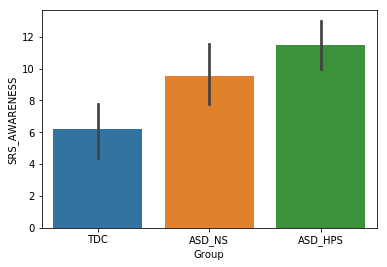

In [121]:
sbn.barplot(x='Group', y='SRS_AWARENESS', data=results)

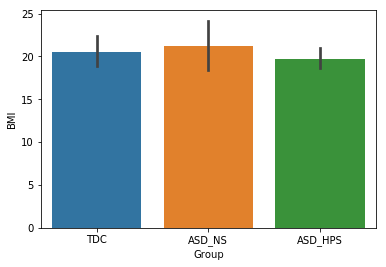

In [108]:
sbn.barplot(x='Group', y='BMI', data=results)